1. Linking Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


2. Loading the Data

In [2]:
import pandas as pd

df = pd.read_excel("/content/drive/MyDrive/Thesis Spring 2025/experiment_results.xlsx")
print(df)

    participant_id condition  words_recalled order_group  age  gender  \
0                1        rw               5    rw_first   27    Male   
1                1        vr               8    rw_first   27    Male   
2                2        rw               2    rw_first   26  Female   
3                2        vr               4    rw_first   26  Female   
4                3        rw               8    vr_first   24    Male   
5                3        vr               8    vr_first   24    Male   
6                4        rw               5    rw_first   23    Male   
7                4        vr               6    rw_first   23    Male   
8                5        rw               6    vr_first   22  Female   
9                5        vr               8    vr_first   22  Female   
10               6        rw               7    vr_first   21  Female   
11               6        vr               7    vr_first   21  Female   
12               7        rw               8    vr_

3. Descriptive Statistics

In [3]:
#Mean and std for real world condition 1
rw_stats = df[df['condition'] == 'rw']['words_recalled'].agg(['mean', 'std'])

#Mean and std for virtual reality condition 2
vr_stats = df[df['condition'] == 'vr']['words_recalled'].agg(['mean', 'std'])

print("Mean of Real World environment:", round(rw_stats['mean'], 2))
print("Standard Deviation of Real World environment:", round(rw_stats['std'], 2))
print("Mean of VR environment:", round(vr_stats['mean'], 2))
print("Standard Deviation of VR environment:", round(vr_stats['std'], 2))


Mean of Real World environment: 5.41
Standard Deviation of Real World environment: 1.57
Mean of VR environment: 6.45
Standard Deviation of VR environment: 2.08


In [4]:
#Minimum and maximum amount of words recalled per condition
rw_min_words = df[df['condition'] == 'rw']['words_recalled'].min()
rw_max_words = df[df['condition'] == 'rw']['words_recalled'].max()
vr_min_words = df[df['condition'] == 'vr']['words_recalled'].min()
vr_max_words = df[df['condition'] == 'vr']['words_recalled'].max()

#All the statistics on age
age_stats = df[['participant_id', 'age']].drop_duplicates()['age'].agg(['mean', 'std', 'min', 'max'])

#Gender counts per condition (should be the same since it is within-subject experiment design)
gender_counts = df.groupby(['condition', 'gender'])['participant_id'].nunique().unstack(fill_value=0)

print(f"RW words recalled: Mean={rw_stats['mean']:.2f}, SD={rw_stats['std']:.2f}, Min={rw_min_words}, Max={rw_max_words}")
print(f"VR words recalled: Mean={vr_stats['mean']:.2f}, SD={vr_stats['std']:.2f}, Min={vr_min_words}, Max={vr_max_words}")

print(f"Age (all participants): Mean={age_stats['mean']:.2f}, SD={age_stats['std']:.2f}, Min={age_stats['min']}, Max={age_stats['max']}\n")

print("Gender counts per condition:")
print(gender_counts)


RW words recalled: Mean=5.41, SD=1.57, Min=2, Max=8
VR words recalled: Mean=6.45, SD=2.08, Min=2, Max=10
Age (all participants): Mean=22.79, SD=3.04, Min=18.0, Max=28.0

Gender counts per condition:
gender     Female  Male
condition              
rw             13    16
vr             13    16


4. Check Basic Statistical Assumptions on the Data

Shapiro-Wilk W statistic: 0.9521
Shapiro-Wilk p-value: 0.2072
The data is normally distributed.


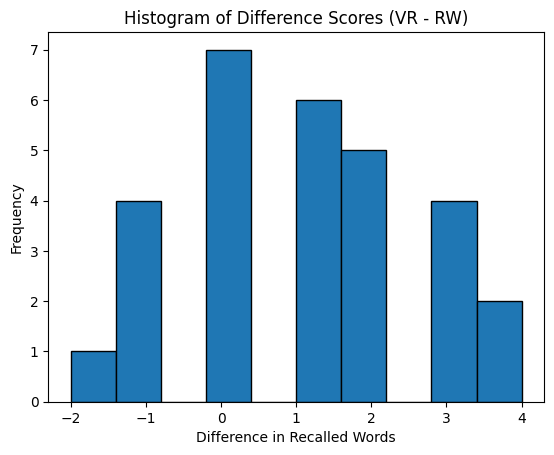

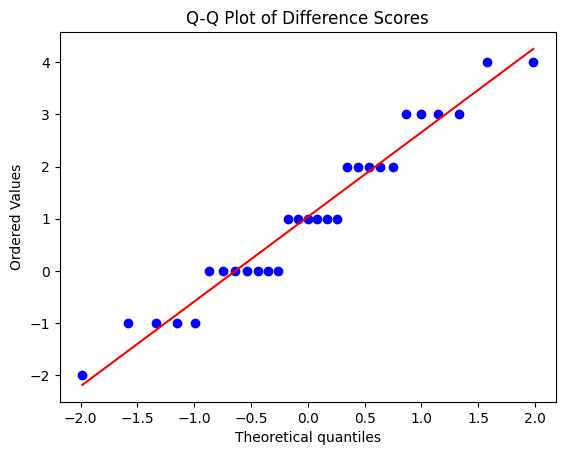

In [5]:
from scipy.stats import shapiro
import matplotlib.pyplot as plt
import scipy.stats as stats

#Pivot the data to wide format so we have one row per participant instead of two
pivoted = df.pivot(index='participant_id', columns='condition', values='words_recalled')

#Calculate difference scores (VR - RW)
pivoted['difference'] = pivoted['vr'] - pivoted['rw']

#Shapiro-Wilk test to check for normality
stat, p = shapiro(pivoted['difference'])
print(f"Shapiro-Wilk W statistic: {stat:.4f}")
print(f"Shapiro-Wilk p-value: {p:.4f}")

if p > 0.05:
    print("The data is normally distributed.")
else:
    print("The data is not normally distributed.")

#Plot histogram and Q-Q plot for visuals in the appendix
plt.hist(pivoted['difference'], bins=10, edgecolor='black')
plt.title("Histogram of Difference Scores (VR - RW)")
plt.xlabel("Difference in Recalled Words")
plt.ylabel("Frequency")
plt.show()

stats.probplot(pivoted['difference'], dist="norm", plot=plt)
plt.title("Q-Q Plot of Difference Scores")
plt.show()


In [7]:
from scipy.stats import levene

rw_scores = df[df['condition'] == 'rw']['words_recalled']
vr_scores = df[df['condition'] == 'vr']['words_recalled']

levene_stat, p = levene(rw_scores, vr_scores)

print("Levene's Test for Equality of Variances:")
print(f"Statistic = {stat:.4f}, p-value = {p:.4f}")

if p > 0.05:
    print("Homogeneity of variance assumption met.")
else:
    print("Homogeneity of variance assumption NOT met.")

Levene's Test for Equality of Variances:
Statistic = 0.9521, p-value = 0.1133
Homogeneity of variance assumption met.


5. Statistical test for significance between Conditions

In [12]:
from scipy import stats

#Perform the paired-samples t-test
t_stat, p_value = stats.ttest_rel(rw_scores, vr_scores)

#Print results
print(f"T-statistic: {t_stat}")
print(f"P-value: {p_value}")

#Check the result against the significance level of 0.05
if p_value < 0.05:
    print("Reject the null hypothesis: Significant difference between RW and VR conditions.")
else:
    print("Fail to reject the null hypothesis: No significant difference between RW and VR conditions.")



T-statistic: -3.4992710611188262
P-value: 0.0015794633016616127
Reject the null hypothesis: Significant difference between RW and VR conditions.


In [13]:
#Calculate the effect size
import numpy as np

diff = pivoted['vr'] - pivoted['rw']
cohen_d = diff.mean() / diff.std(ddof=1)

print(f"Cohen's d: {cohen_d:.3f}")

Cohen's d: 0.650


6. Interpret IPQ Results to find correlations with words recalled

In [15]:
from scipy.stats import pearsonr

#Filter only the VR condition, since IPQ was measured there
vr_df = df[df["condition"] == "vr"]

#List of IPQ subscales
ipq_columns = ["ipq_score_sp", "ipq_score_inv", "ipq_score_real", "ipq_score_pr"]

#Descriptive statistics
print("Descriptive Statistics for IPQ Scores in the VR Condition")
print(vr_df[ipq_columns].describe())

#Correlation with words recalled
print("Correlation of IPQ Scores with Words Recalled (VR Condition)")
for col in ipq_columns:
    corr, p = pearsonr(vr_df[col], vr_df["words_recalled"])
    print(f"{col}: r = {corr:.2f}, p = {p:.3f}")


Descriptive Statistics for IPQ Scores in the VR Condition
       ipq_score_sp  ipq_score_inv  ipq_score_real  ipq_score_pr
count     29.000000      29.000000       29.000000     29.000000
mean       1.710345       1.637931        0.396552      1.965517
std        0.479840       0.625308        0.580629      0.778403
min        0.600000       0.500000       -0.500000      1.000000
25%        1.400000       1.250000        0.000000      1.000000
50%        1.800000       1.500000        0.500000      2.000000
75%        2.000000       2.250000        1.000000      3.000000
max        2.400000       2.750000        1.500000      3.000000
Correlation of IPQ Scores with Words Recalled (VR Condition)
ipq_score_sp: r = 0.37, p = 0.048
ipq_score_inv: r = 0.50, p = 0.006
ipq_score_real: r = -0.01, p = 0.951
ipq_score_pr: r = 0.47, p = 0.010
